# Stimulus Reconstruction with TRF model

This notebook demonstrates how to use the TRF model in ``naplib-python`` to do stimulus reconstruction from neural recordings. This is a technique where the auditory stimulus is reconstructed from the electrode responses. Here, we will train a linear TRF model to reconstruct the stimulus spectrogram using 250 ms of responses from a group of electrodes.

For more information on stimulus reconstruction and its uses, please see the following papers:

- Mesgarani, Nima, et al. "Influence of context and behavior on stimulus reconstruction from neural activity in primary auditory cortex." Journal of neurophysiology 102.6 (2009): 3329-3339. https://journals.physiology.org/doi/full/10.1152/jn.91128.2008

- Pasley, Brian N., et al. "Reconstructing speech from human auditory cortex." PLoS biology 10.1 (2012): e1001251. https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1001251


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import naplib as nl

In [2]:
data = nl.io.import_outstruct('../out_structs/out_clean.mat')


In [29]:
# This data contains 48 electrodes of simultaneous recording
data['resp'][0].shape

(6197, 48)

In [3]:
data['resp'] = nl.preprocessing.normalize(data, 'resp')

len(data) # number of trials in this data

18

In [4]:
data['aud'] = [x[:y.shape[0]] for x, y in zip(data['aud'], data['resp'])]

In [5]:
# Since the spectrogram is 128-channels, which is very large, we downsample it
from scipy.signal import resample

print(f"before resampling: {data['aud'][0].shape}")

resample_kwargs = {'num': 32, 'axis': 1}
data['aud_32channel'] = nl.array_ops.concat_apply(data['aud'], resample, function_kwargs=resample_kwargs)

print(f"after resampling:  {data['aud_32channel'][0].shape}")


before resampling: (6197, 128)
after resampling:  (6197, 32)


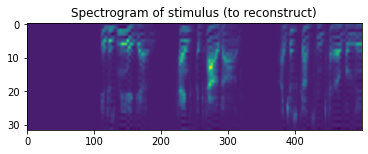

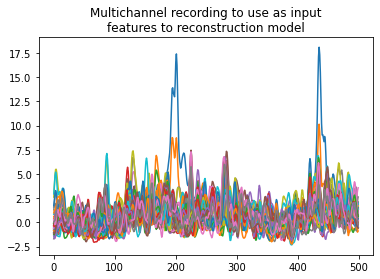

In [6]:
plt.figure()
plt.imshow(data[0]['aud_32channel'][:500,:].T, aspect=5)
plt.title('Spectrogram of stimulus (to reconstruct)')
plt.show()


plt.figure()
plt.plot(data[0]['resp'][:500])
plt.title('Multichannel recording to use as input\nfeatures to reconstruction model')
plt.show()


## Train single TRF model to reconstruct all frequency bins as a single output channel with multiple dimensions

First, we reshape the stimulus spectrograms to be (time * 1 * frequency), because if they are just (time * frequency), then a separate model will be trained for each frequency bin

In [16]:
data['reshaped_aud'] = [x[:,np.newaxis,:][:,:,:-4] for x in data['aud_32channel']]
print(data['reshaped_aud'][0].shape)

(6197, 1, 28)


In [17]:
# separate into train and test sections
data_train = data[1:]
data_test = data[:1]


In [18]:
# model parameters
tmin = -0.25 # 250 ms window from the neural response is used to reconstruct the next time sample of the stimulus
tmax = 0
sfreq = 100

In [19]:
# train model
mdl = nl.encoding.TRF(tmin=tmin, tmax=tmax, sfreq=sfreq, scoring='r2', alpha=np.logspace(2, 6, 8), verbose=2)
mdl.fit(data_train, X='resp', y='reshaped_aud')


  0%|          | 0/1 [00:00<?, ?it/s]

Fitting model for output variable 0...
Running cross-validation on alphas...
Cross-validation scores:
alpha=1.00e+02 : -3.8148
alpha=3.73e+02 : -3.8326
alpha=1.39e+03 : -3.8738
alpha=5.18e+03 : -3.9826
alpha=1.93e+04 : -4.2727
alpha=7.20e+04 : -4.9761
alpha=2.68e+05 : -6.5573
alpha=1.00e+06 : -9.8749
chose alpha=1.00e+02



TRF(alpha=array([1.00000000e+02, 3.72759372e+02, 1.38949549e+03, 5.17947468e+03,
       1.93069773e+04, 7.19685673e+04, 2.68269580e+05, 1.00000000e+06]),
    scoring='r2', sfreq=100.0, tmax=0, tmin=-0.25, verbose=2)

In [20]:
reconstructed_stims = mdl.predict(data_test, X='resp')
len(reconstructed_stims), reconstructed_stims[0].shape

(1, (6197, 1, 28))

In [21]:
corr = np.corrcoef(data_test[0]['reshaped_aud'].reshape(-1,), reconstructed_stims[0].reshape(-1,))[0,1]


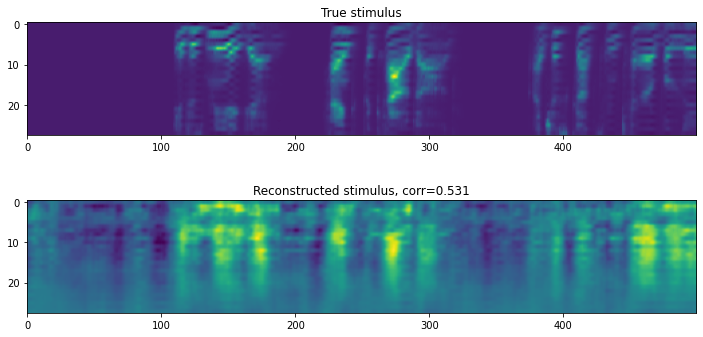

In [22]:
region = slice(0, 500)

fig, axes = plt.subplots(2,1,figsize=(12,6))

axes[0].imshow(data_test[0]['reshaped_aud'].squeeze()[region].T, aspect=3)
axes[0].set_title('True stimulus')
axes[1].imshow(reconstructed_stims[0].squeeze()[region].T, aspect=3)
axes[1].set_title('Reconstructed stimulus, corr={:.3f}'.format(corr))

plt.show()

## Train a TRF model for each frequency bin, reconstructing each bin individually

For this, we can use the spectrogram which is shape (time * frequency), instead of the reshaped spectrogram, since the TRF model will automatically train a single model for each channel in the second dimension of the `y` variable.

In [24]:
# train model
mdl = nl.encoding.TRF(tmin=tmin, tmax=tmax, sfreq=sfreq, scoring='r2', alpha=np.logspace(2, 6, 8), verbose=1)
mdl.fit(data_train, X='resp', y='aud_32channel')


  0%|          | 0/32 [00:00<?, ?it/s]

TRF(alpha=array([1.00000000e+02, 3.72759372e+02, 1.38949549e+03, 5.17947468e+03,
       1.93069773e+04, 7.19685673e+04, 2.68269580e+05, 1.00000000e+06]),
    scoring='r2', sfreq=100.0, tmax=0, tmin=-0.25)

In [25]:
reconstructed_stims_bychannel = mdl.predict(data_test, X='resp')
len(reconstructed_stims_bychannel), reconstructed_stims_bychannel[0].shape

(1, (6197, 32))

In [26]:
corr = np.corrcoef(data_test[0]['aud_32channel'].reshape(-1,), reconstructed_stims_bychannel[0].reshape(-1,))[0,1]


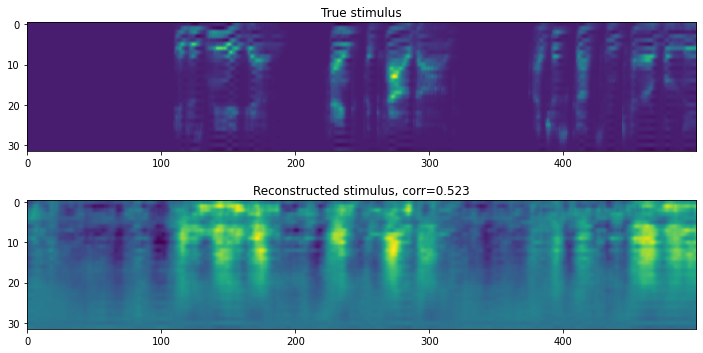

In [28]:
region = slice(0, 500)

fig, axes = plt.subplots(2,1,figsize=(12,6))

axes[0].imshow(data_test[0]['aud_32channel'].squeeze()[region].T, aspect=3)
axes[0].set_title('True stimulus')
axes[1].imshow(reconstructed_stims_bychannel[0].squeeze()[region].T, aspect=3)
axes[1].set_title('Reconstructed stimulus, corr={:.3f}'.format(corr))

plt.show()